# Comparison between ELM and FastELM

This file contains comparisons between a single ELM and the FastELM accross multiple datasets.

All comparisons are made in the same way:
- the eigen decomposition of the K matrix constrained to obtain the eigenvalues of modulus greater than a certain threshold determines the maximum number of neurons to be considered;
- performance of the ELM and the FastELM are considered as the number of neurons varies from 1 to the previously identified threshold value;
- performance is measured by calculating the training RMSE and testing RMSE.

The datasets currently considered are:
- Linear (1 dim.)
- Linear (3 dim.)
- Linear (10 dim.)
- Linear (30 dim.)
- Linear (100 dim.)
- Sin
- Cos
- SinC
- 2nd degree polynomial (1 dim.)
- 2nd degree polynomial (3 dim.)
- 2nd degree polynomial (10 dim.)
- 2nd degree polynomial (30 dim.)
- 2nd degree polynomial (100 dim.)
- Friedman I (5 dim.)
- Friedman I (30 dim.)
- Friedman I (100 dim.)
- Friedman II
- Friedman III

### Linear (1 dim.)

In [1]:
#resets the environment
%reset -f -s 

In [2]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [3]:
seed_train_test_split = 1234
T = 300
n0 = 1
noise = 0.1
generator = datagenerator.LinearGenerator(T, n0, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



linear_dim_1


In [4]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
4


In [5]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [6]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.229387
0.0


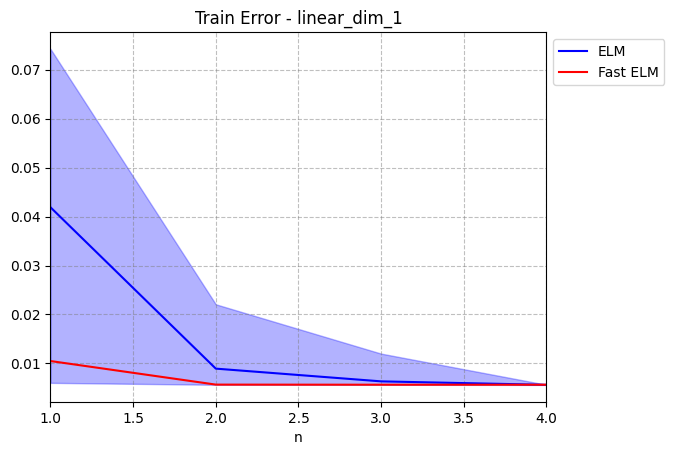

In [7]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.229387
0.0


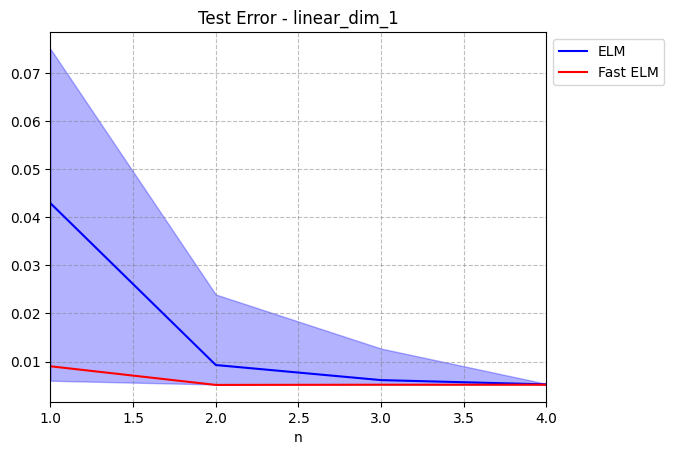

In [8]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Linear (3 dim.)

In [9]:
#resets the environment
%reset -f -s 

In [10]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [11]:
seed_train_test_split = 1234
T = 300
n0 = 3
noise = 0.1
generator = datagenerator.LinearGenerator(T, n0, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



linear_dim_3


In [12]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
L, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
128


In [13]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [14]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.1795209
0.40591480000000013


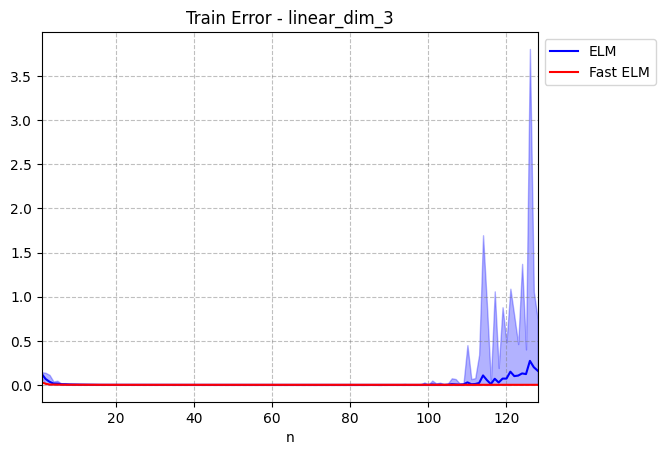

In [15]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.1795209
0.40591480000000013


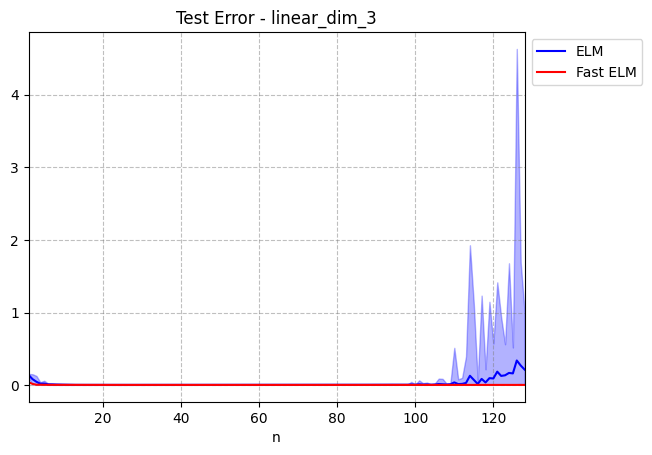

In [16]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Linear (10 dim.)

In [17]:
#resets the environment
%reset -f -s 

In [18]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [19]:
seed_train_test_split = 1234
T = 300
n0 = 10
noise = 0.1
generator = datagenerator.LinearGenerator(T, n0, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



linear_dim_10


In [20]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
L, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
202


In [21]:
import scipy
a,b,c = np.linalg.svd(scipy.special.erf(X_train @ elm.W))

In [22]:
a.T @ U

array([[-3.30053173e-01,  5.30676302e-01, -1.61408633e-01, ...,
        -1.37265579e-02, -7.00390759e-05,  3.07198869e-03],
       [ 1.11711276e-01, -1.48020536e-01,  3.91935289e-01, ...,
        -1.02100495e-03, -1.58857789e-02, -1.16400630e-02],
       [-6.10122444e-01, -6.06097913e-02,  3.50635454e-01, ...,
         1.57740266e-03, -4.28786687e-03, -5.06078935e-03],
       ...,
       [-2.94144418e-04, -3.19566632e-03, -3.12996068e-03, ...,
         1.57584868e-01, -2.94240942e-02, -1.56100767e-02],
       [ 5.59332319e-03,  6.59331547e-03,  4.52344780e-03, ...,
         2.47473729e-02,  1.59369545e-02,  4.93773059e-03],
       [-6.61603754e-03, -3.49856518e-03, -1.47906919e-03, ...,
        -6.82213769e-02,  2.45891252e-02,  3.77876015e-02]])

In [23]:
c.T @ U

array([[ 0.05615711,  0.08183663, -0.03306881, ..., -0.10520592,
        -0.01342241,  0.00079854],
       [-0.10010111, -0.11497552,  0.02314938, ..., -0.0417058 ,
         0.05010856, -0.00644021],
       [ 0.10594254,  0.06083127,  0.07952425, ..., -0.03066893,
        -0.02935646,  0.04852289],
       ...,
       [ 0.08239897, -0.01029155, -0.11800345, ...,  0.01326756,
        -0.15655464, -0.09228386],
       [-0.07067007, -0.01639072,  0.08547926, ..., -0.00149203,
         0.06571183,  0.05961868],
       [ 0.00124283, -0.03693864,  0.01916271, ...,  0.11344715,
        -0.03904226,  0.07319374]])

In [24]:
a1,b1,c1 = np.linalg.svd(U)

In [25]:
b

array([1.00014701e+00, 1.00006278e+00, 1.00000555e+00, 9.99993268e-01,
       9.99878204e-01, 9.99786707e-01, 9.99773608e-01, 9.99676035e-01,
       9.99603044e-01, 9.98986020e-01, 3.96625419e-04, 3.63712920e-04,
       3.30900403e-04, 3.12804394e-04, 2.96433889e-04, 2.64481727e-04,
       2.56896605e-04, 2.45139533e-04, 2.27407045e-04, 2.03344265e-04,
       5.37197561e-07, 2.26944081e-07, 2.13437675e-07, 2.02605291e-07,
       1.91891924e-07, 1.83196523e-07, 1.76095776e-07, 1.71523856e-07,
       1.67398783e-07, 1.56130910e-07, 1.46697230e-07, 1.43838531e-07,
       1.40943388e-07, 1.34366158e-07, 1.29316991e-07, 1.21914108e-07,
       1.20239449e-07, 1.16937207e-07, 1.15078193e-07, 1.10286656e-07,
       1.09058899e-07, 1.04582430e-07, 1.00068772e-07, 9.94969886e-08,
       9.79975995e-08, 9.33370624e-08, 9.13603170e-08, 8.82924817e-08,
       8.63551928e-08, 8.41979124e-08, 8.23006525e-08, 7.99093954e-08,
       7.85730665e-08, 7.73487167e-08, 7.60198789e-08, 7.45717393e-08,
      

In [26]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [27]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.2199694
0.9970026999999997


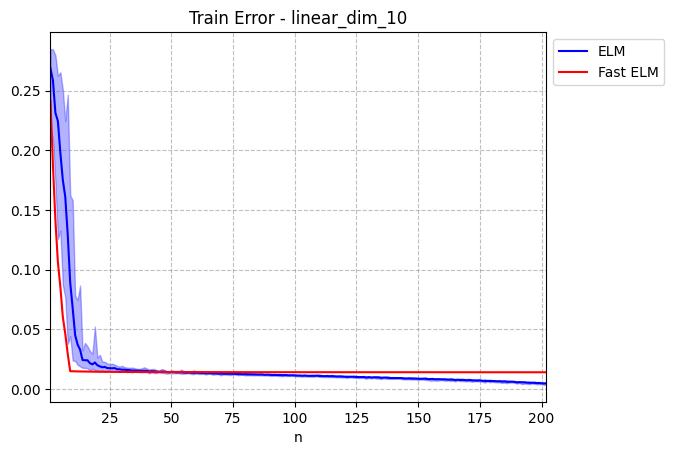

In [28]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.2199694
0.9970026999999997


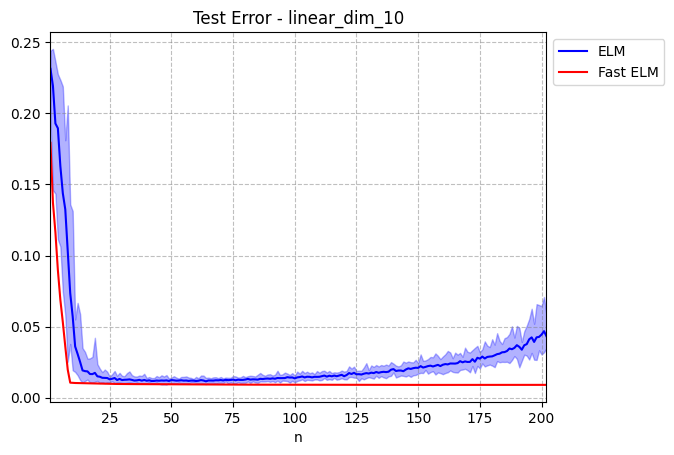

In [29]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Linear (30 dim.)

In [30]:
#resets the environment
%reset -f -s 

In [31]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [32]:
seed_train_test_split = 1234
T = 300
n0 = 30
noise = 0.1
generator = datagenerator.LinearGenerator(T, n0, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



linear_dim_30


In [33]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
202


In [34]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [35]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.2912226
1.6316286999999998


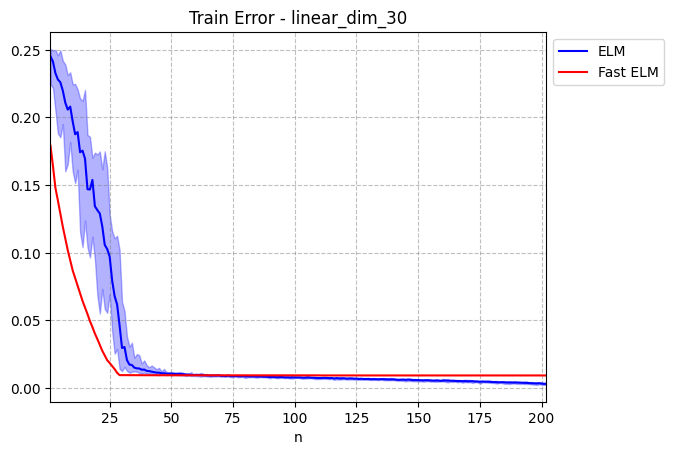

In [36]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.2912226
1.6316286999999998


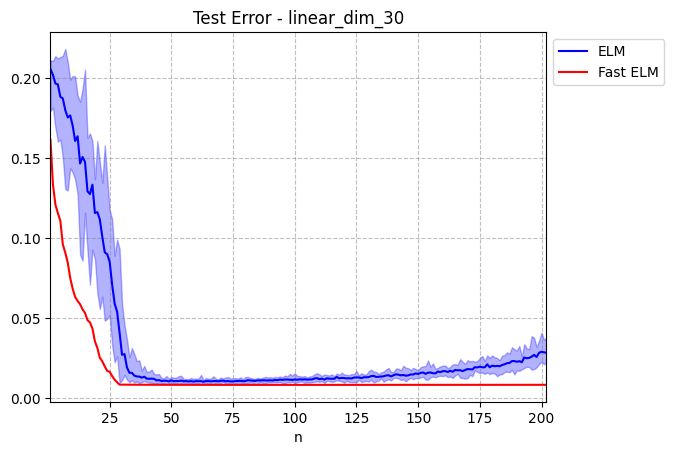

In [37]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Linear (100 dim.)

In [38]:
#resets the environment
%reset -f -s 

In [39]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [40]:
seed_train_test_split = 1234
T = 300
n0 = 100
noise = 0.1
generator = datagenerator.LinearGenerator(T, n0, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



linear_dim_100


In [41]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
202


In [42]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [43]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.4029217
1.1848302


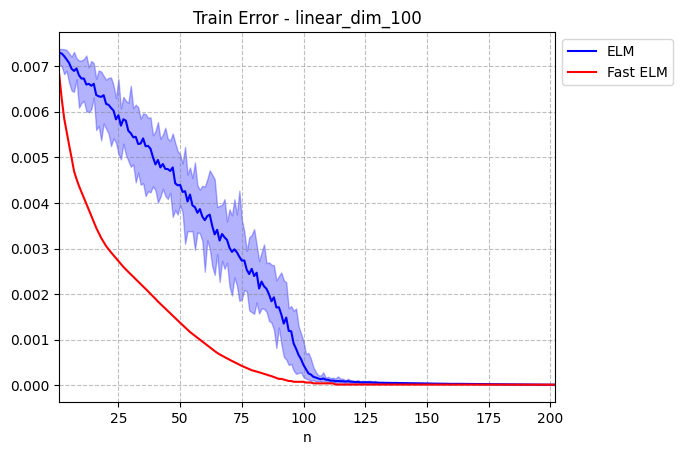

In [44]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.4029217
1.1848302


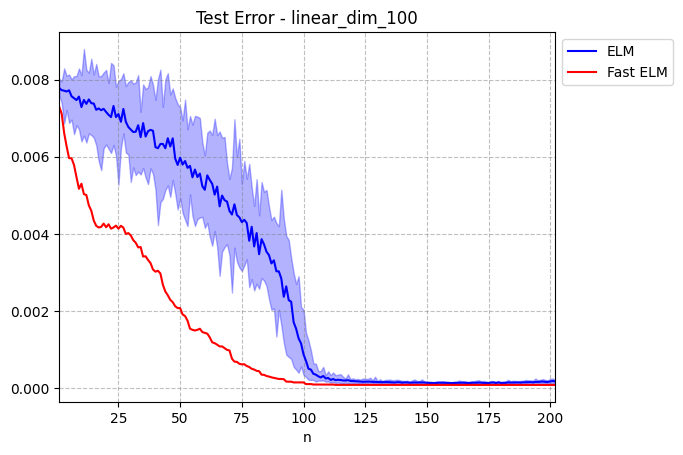

In [45]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Sin

In [46]:
#resets the environment
%reset -f -s 

In [47]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [48]:
seed_train_test_split = 1234
T = 300

noise = 0.1
generator = datagenerator.SinGenerator(T, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)

n0 = X_train.shape[1]

sin


In [49]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
L, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
4


In [50]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [51]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.1346396
0.0


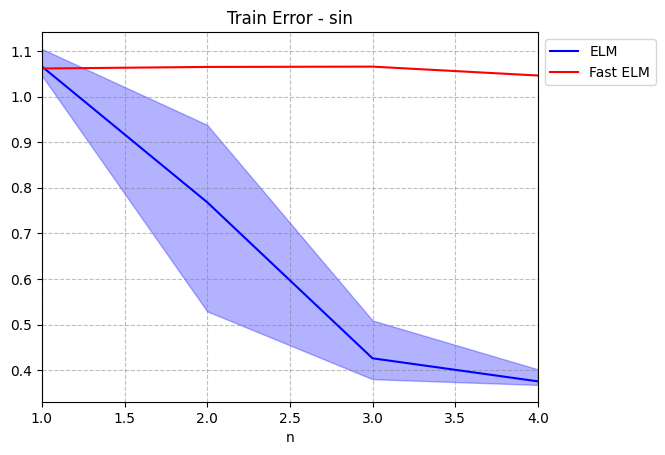

In [52]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.1346396
0.0


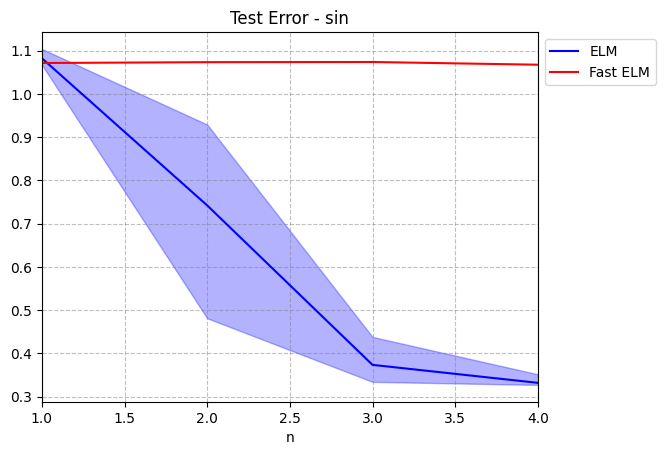

In [53]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Cos

In [54]:
#resets the environment
%reset -f -s 

In [55]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [56]:
seed_train_test_split = 1234
T = 300

noise = 0.1
generator = datagenerator.CosGenerator(T, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)

n0 = X_train.shape[1]

cos


In [57]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
4


In [58]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [59]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.1745325
0.0009975


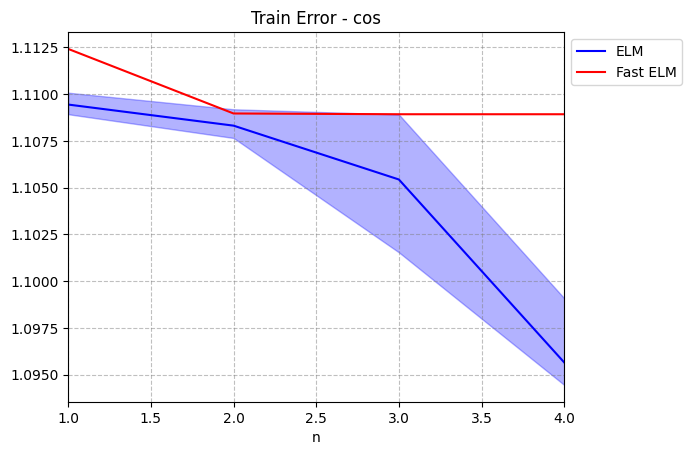

In [60]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.1745325
0.0009975


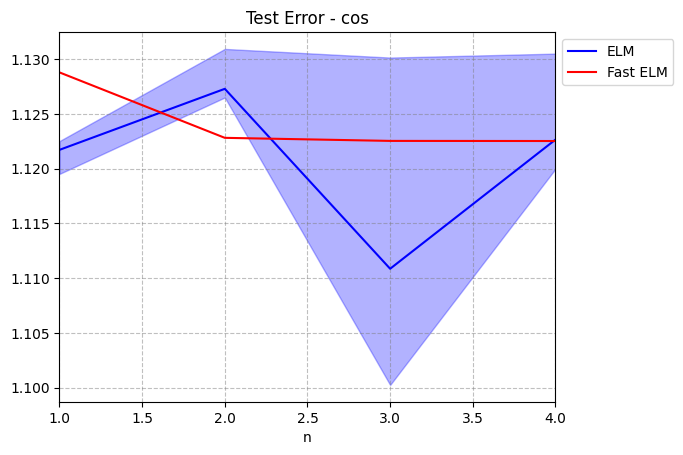

In [61]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### SinC

In [62]:
#resets the environment
%reset -f -s 

In [63]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [64]:
seed_train_test_split = 1234
T = 300
n0 = 1
noise = 0.1
generator = datagenerator.SinCGenerator(T,noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



sinC


In [65]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
4


In [66]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [67]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.0399261
0.000997


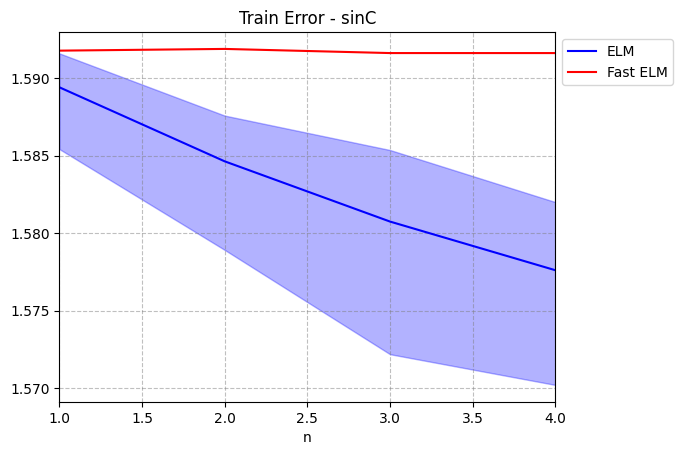

In [68]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.0399261
0.000997


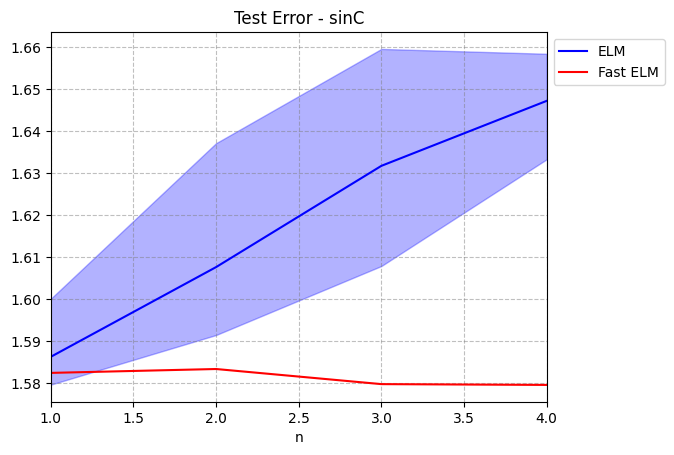

In [69]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### 2nd degree polynomial (1 dim.)

In [70]:
#resets the environment
%reset -f -s 

In [71]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [72]:
seed_train_test_split = 1234
T = 300
n0 = 1
noise = 0.1
generator = datagenerator.QuadraticGenerator(T, n0, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



quadratic_dim_1


In [73]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
4


In [74]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [75]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.1635607
0.0010034


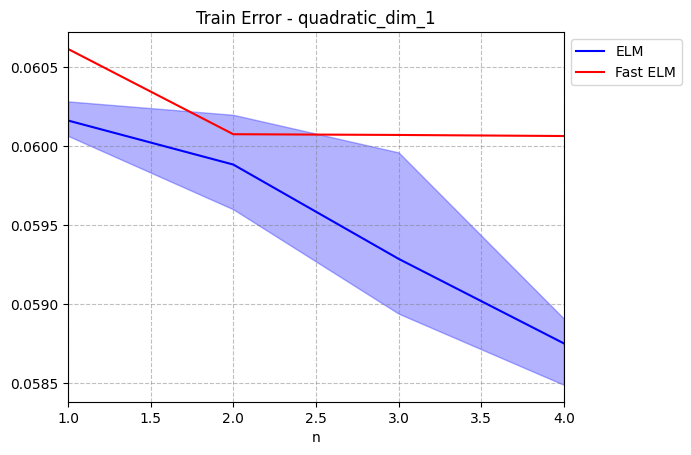

In [76]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.1635607
0.0010034


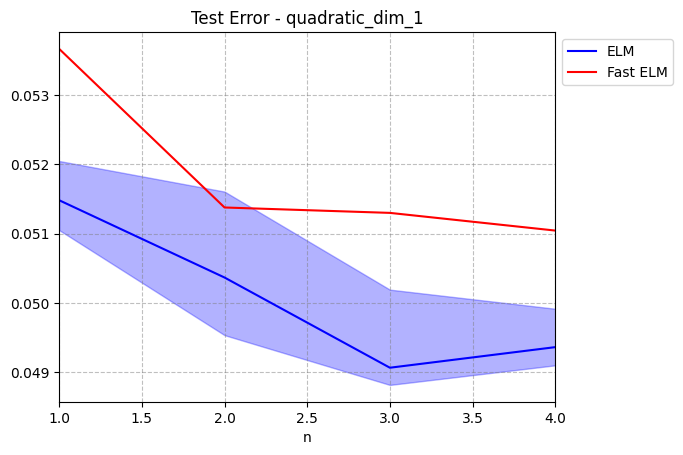

In [77]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### 2nd degree polynomial (3 dim.)

In [50]:
#resets the environment
%reset -f -s 

In [51]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [52]:
seed_train_test_split = 1234
T = 300
n0 = 3
noise = 0.1
generator = datagenerator.QuadraticGenerator(T, n0, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



quadratic_dim_3


In [53]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
130


In [54]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [55]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.3394674
0.3171197


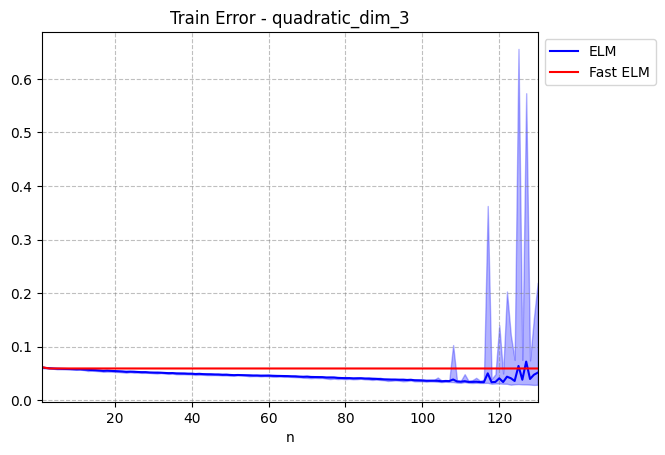

In [56]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.3394674
0.3171197


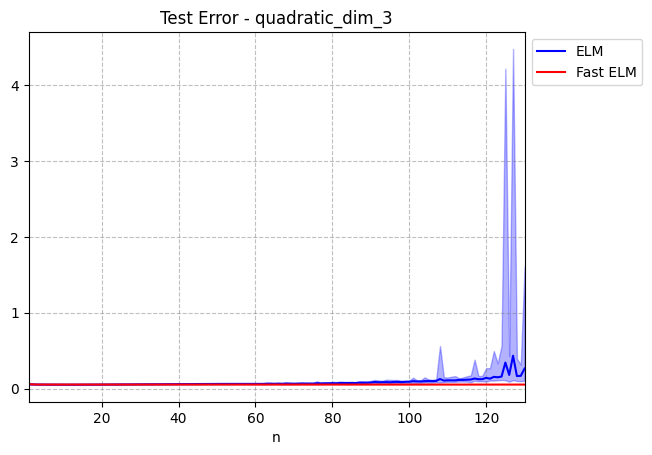

In [57]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### 2nd degree polynomial (10 dim.)

In [106]:
#resets the environment
%reset -f -s 

In [107]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [108]:
seed_train_test_split = 1234
T = 300
n0 = 10
noise = 0.1
generator = datagenerator.QuadraticGenerator(T, n0, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



quadratic_dim_10


In [109]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
L, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-2, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
202


In [110]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [111]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.3052487
0.6833035000000001


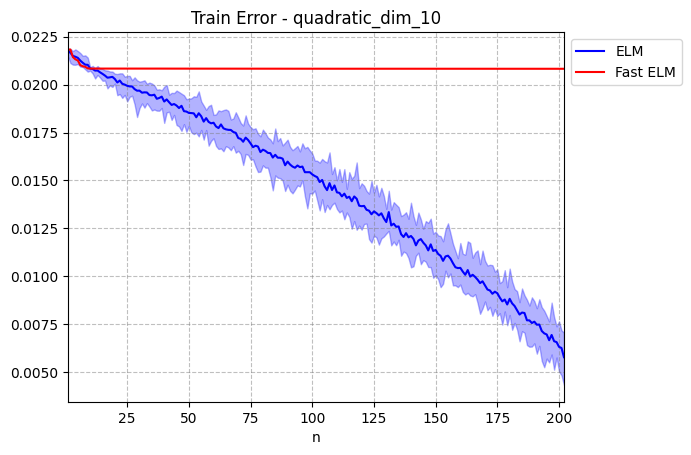

In [112]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.3052487
0.6833035000000001


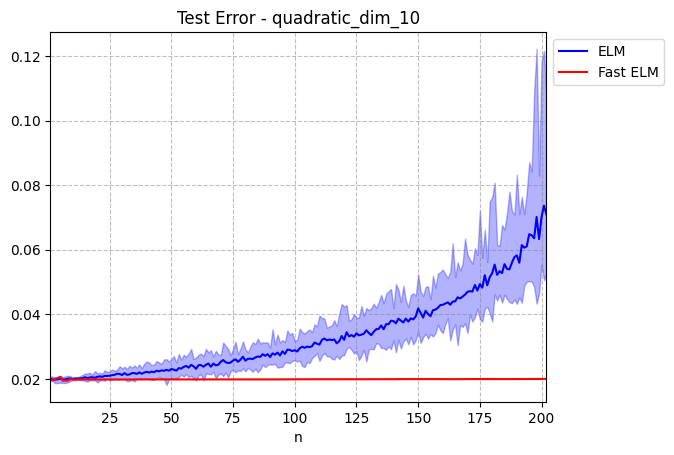

In [113]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### 2nd degree polynomial (30 dim.)

In [114]:
#resets the environment
%reset -f -s 

In [115]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [116]:
seed_train_test_split = 1234
T = 300
n0 = 30
noise = 0.1
generator = datagenerator.QuadraticGenerator(T, n0, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



quadratic_dim_30


In [117]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
202


In [118]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [119]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.3187976
0.6879644999999999


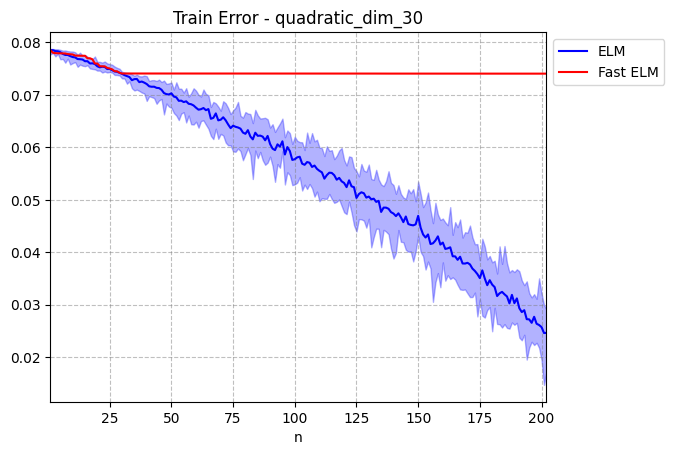

In [120]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.3187976
0.6879644999999999


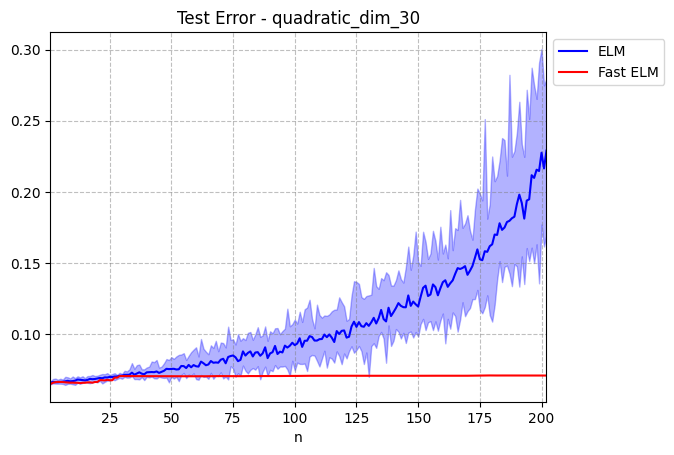

In [121]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### 2nd degree polynomial (100 dim.)

In [122]:
#resets the environment
%reset -f -s 

In [123]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [124]:
seed_train_test_split = 1234
T = 300
n0 = 100
noise = 0.1
generator = datagenerator.QuadraticGenerator(T, n0, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



quadratic_dim_100


In [125]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
L, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-1, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
202


In [126]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [127]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.2722253
0.9830918000000001


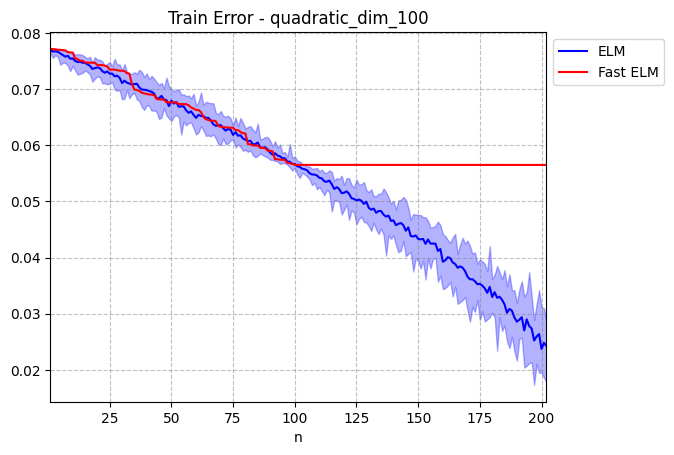

In [129]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-')
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.2722253
0.9830918000000001


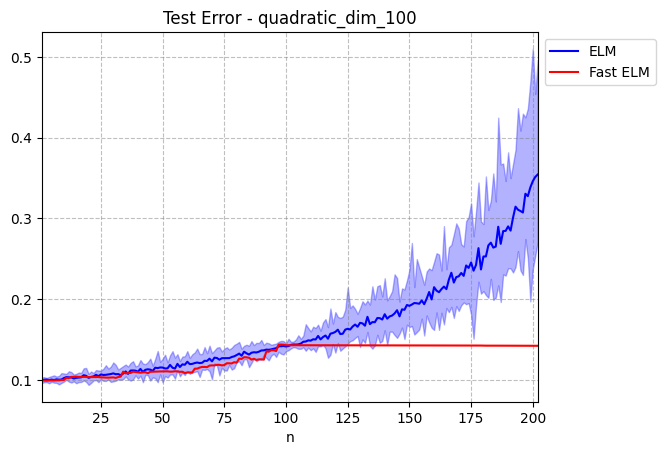

In [130]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-')
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Friedman 1 (5 dim.)

In [6]:
#resets the environment
%reset -f -s 

In [7]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [8]:
seed_train_test_split = 1234
T = 300
n0 = 5
noise = 0.1
generator = datagenerator.Friedman1Generator(T=T, n0=n0, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



friedman_1_dim_5


In [11]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
L, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
202


In [10]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


KeyboardInterrupt: 

In [136]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.2289535
0.5628387999999999


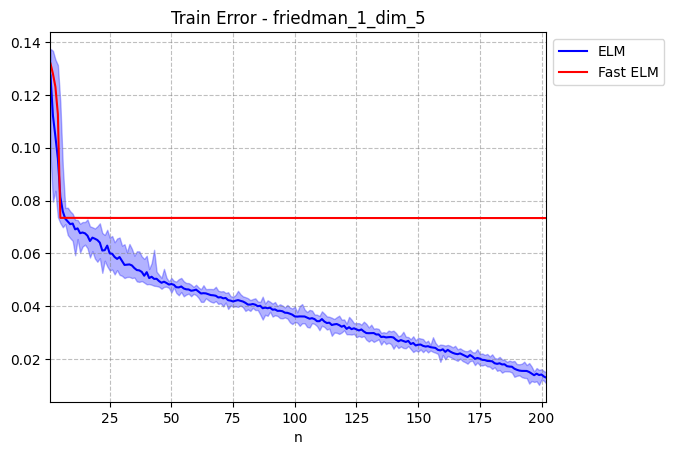

In [137]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.2289535
0.5628387999999999


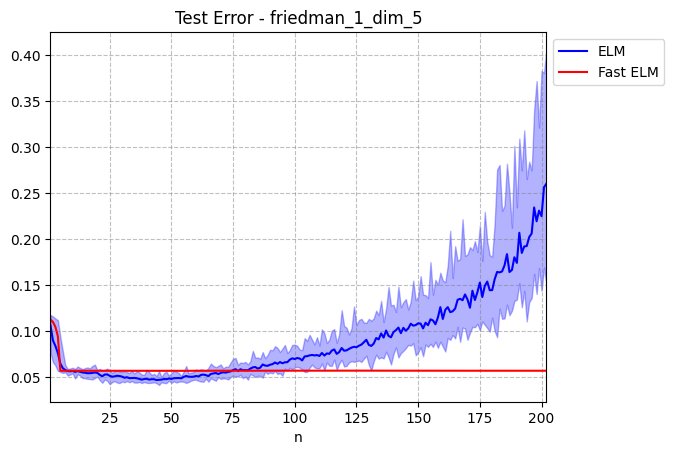

In [138]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Friedman 1 (30 dim.)

In [139]:
#resets the environment
%reset -f -s 

In [140]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [141]:
seed_train_test_split = 1234
T = 300
n0 = 30
noise = 0.1
generator = datagenerator.Friedman1Generator(T, n0, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



friedman_1_dim_30


In [142]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
202


In [143]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [144]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.2258142
0.5161395


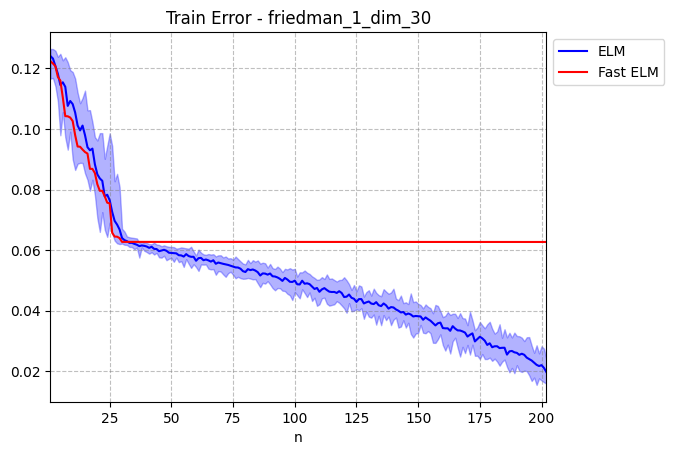

In [145]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.2258142
0.5161395


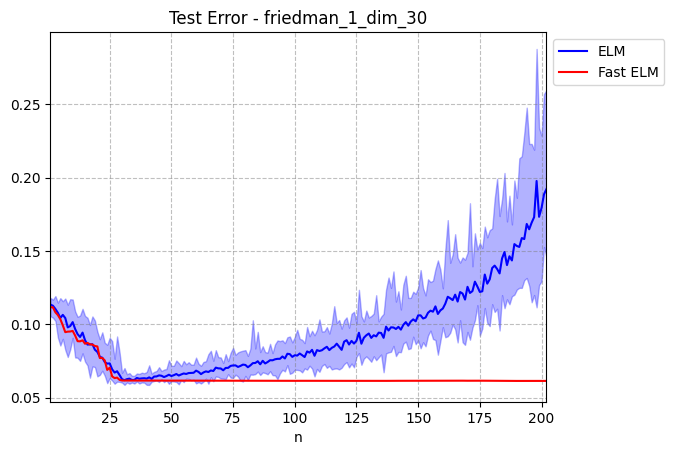

In [146]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Friedman 1 (100 dim.)

In [1]:
#resets the environment
%reset -f -s 

In [2]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [3]:
seed_train_test_split = 1234
T = 300
n0 = 100
noise = 0.1
generator = datagenerator.Friedman1Generator(T, n0, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)



friedman_1_dim_100


In [4]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
L, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
202


In [5]:
L[90:110]

array([0.61212211, 0.6009433 , 0.58883591, 0.57192471, 0.56004327,
       0.54505288, 0.52401108, 0.52017193, 0.48659756, 0.45958551,
       0.30690892, 0.30626264, 0.30608866, 0.30583413, 0.3057249 ,
       0.30563962, 0.30546644, 0.30523889, 0.30505725, 0.30486126])

In [151]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [152]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.2442036
0.6873366000000002


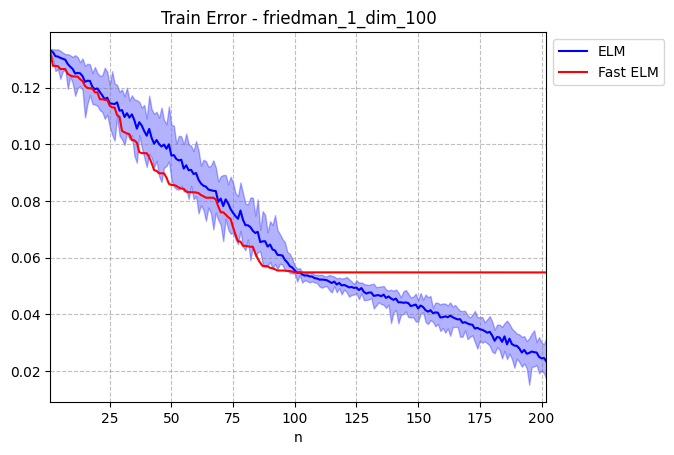

In [153]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.2442036
0.6873366000000002


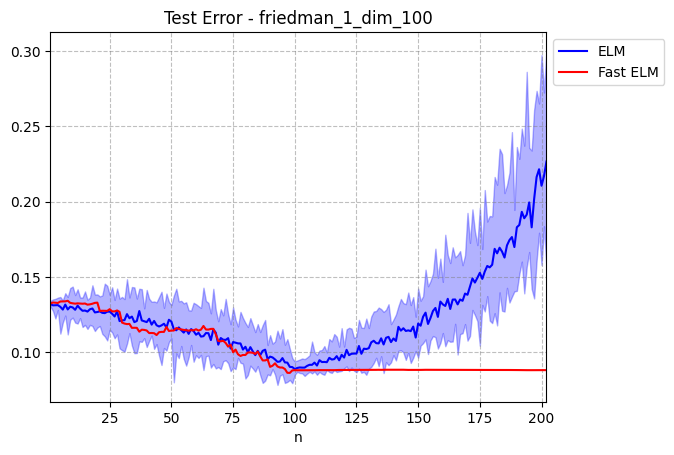

In [154]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Friedman 2

In [112]:
#resets the environment
%reset -f -s 

In [113]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os


In [114]:
seed_train_test_split = 1234
T = 300

noise = 0.1
generator = datagenerator.Friedman2Generator(T, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)

n0 = X_train.shape[1]

friedman_2


In [115]:
import scipy

In [116]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
L, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
202


In [117]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [160]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

2.4934939
14.714135800000005


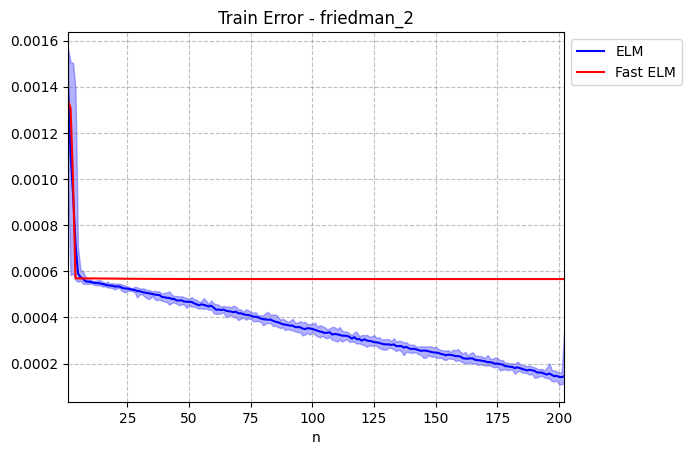

In [120]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


2.4934939
14.714135800000005


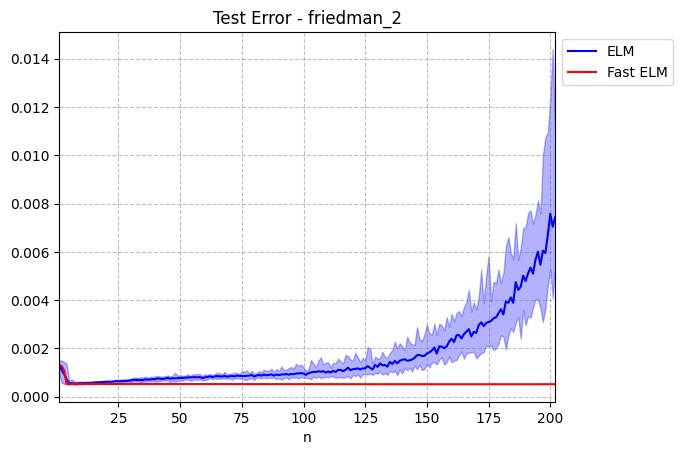

In [121]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Friedman 3

In [163]:
#resets the environment
%reset -f -s 

In [164]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os


In [165]:
seed_train_test_split = 1234
T = 300

noise = 0.1
generator = datagenerator.Friedman3Generator(T, noise = noise)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)

n0 = X_train.shape[1]

friedman_3


In [166]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
202


In [167]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [168]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.2057921
0.5661388


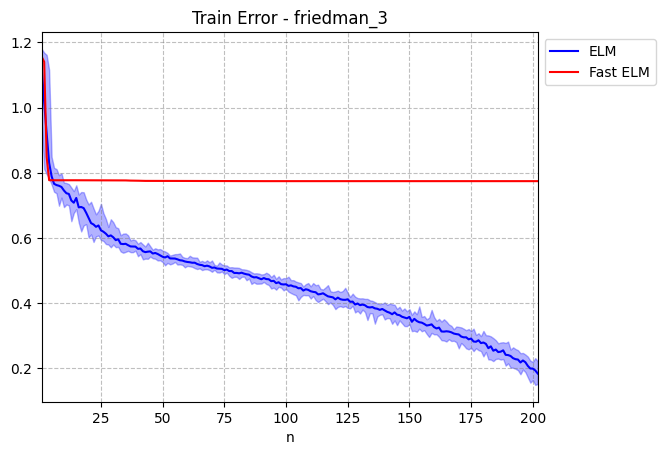

In [169]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.2057921
0.5661388


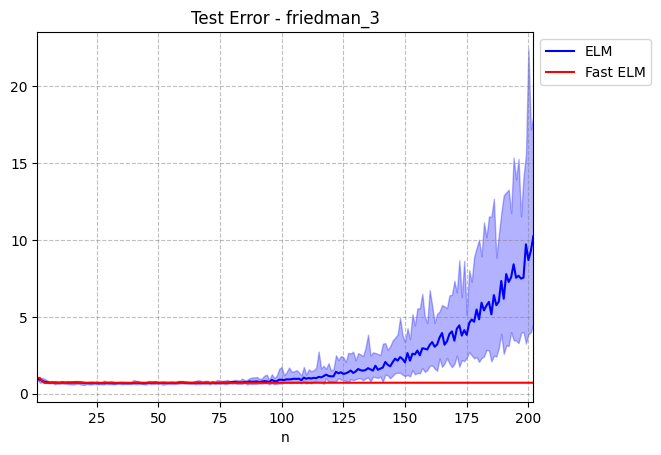

In [170]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Auto-MPG

In [1]:
#resets the environment
%reset -f -s 

In [2]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os


In [3]:
seed_train_test_split = 1234

generator = datagenerator.LoaderDataGenerator("Auto-MPG", dataloader.load_auto_mpg)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)

T = X_train.shape[0]
n0 = X_train.shape[1]
print("dataset shape: " + str(X.shape))

Auto-MPG
dataset shape: (392, 21)


In [4]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
264


In [5]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [6]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.3220704
1.7866662000000004


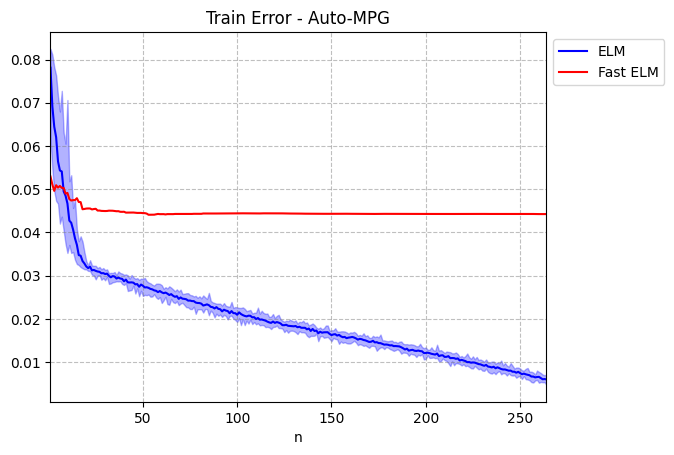

In [7]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.3220704
1.7866662000000004


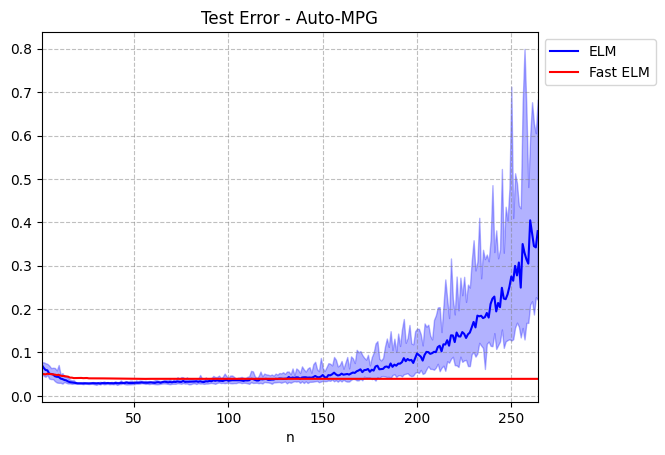

In [8]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Servo

In [9]:
#resets the environment
%reset -f -s 

In [10]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [11]:
seed_train_test_split = 1234


noise = 0.1
generator = datagenerator.LoaderDataGenerator("Servo", dataloader.load_servo)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)

T = X_train.shape[0]
n0 = X_train.shape[1]
print("dataset shape: " + str(X.shape))

Servo
dataset shape: (167, 19)


In [12]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
112


In [13]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [14]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.0472428
0.14033340000000005


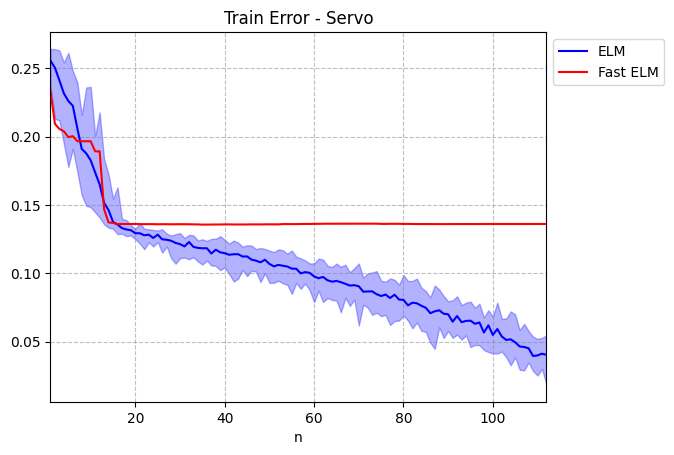

In [15]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.0472428
0.14033340000000005


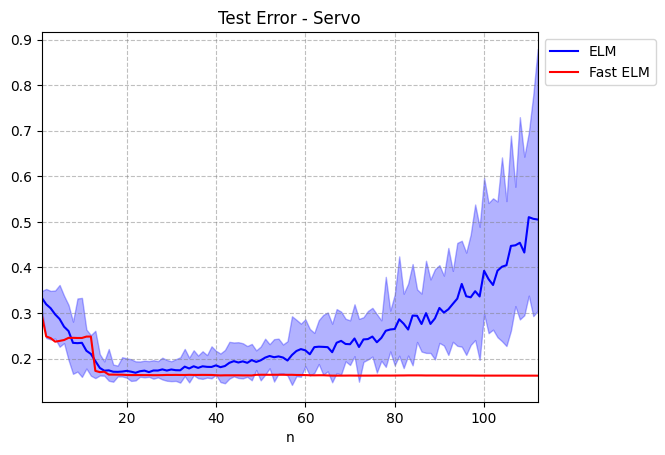

In [16]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Machine-CPU

In [1]:
#resets the environment
%reset -f -s 

In [18]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [19]:
seed_train_test_split = 1234

generator = datagenerator.LoaderDataGenerator("Machine-CPU", dataloader.load_machine_cpu)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)

T = X_train.shape[0]
n0 = X_train.shape[1]
print("dataset shape: " + str(X.shape))

Machine-CPU
dataset shape: (209, 6)


In [20]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
129


In [21]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [22]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.0543201
0.2220278000000001


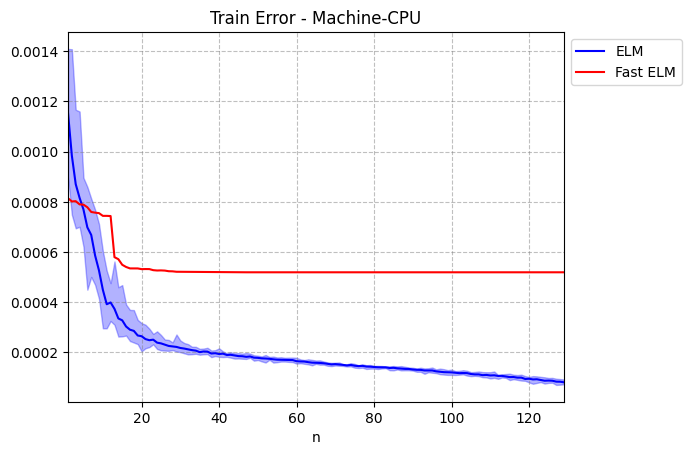

In [23]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.0543201
0.2220278000000001


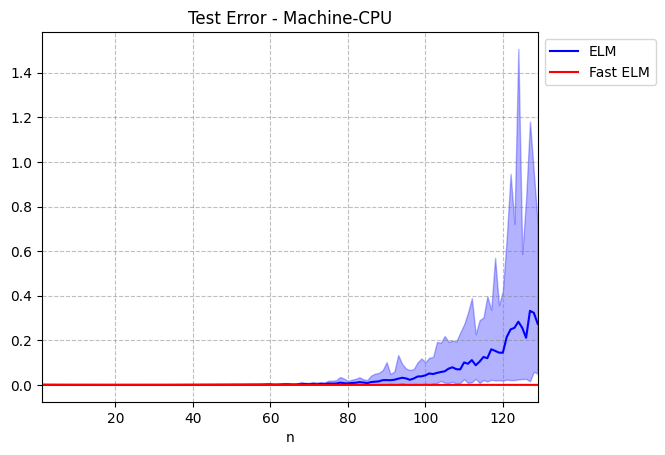

In [24]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Delta-Ailerons

In [195]:
#resets the environment
%reset -f -s 

In [196]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os


In [197]:
seed_train_test_split = 1234


generator = datagenerator.LoaderDataGenerator("Delta-Ailerons", dataloader.load_delta_ailerons)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)
T = X_train.shape[0]
n0 = X_train.shape[1]
print("dataset shape: " + str(X.shape))

Delta-Ailerons
dataset shape: (7129, 5)


In [198]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
2990


In [199]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [ ]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.1251259
0.14446769999999995


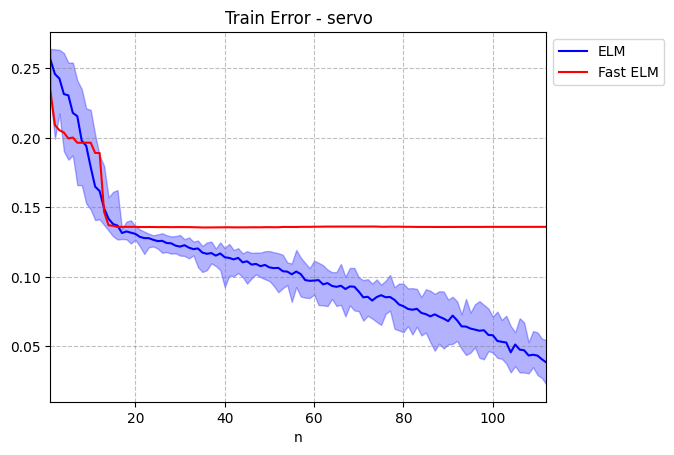

In [ ]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.1251259
0.14446769999999995


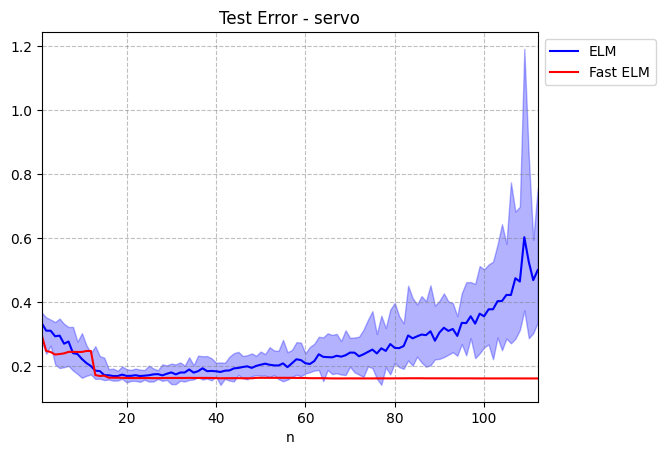

In [ ]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Prostate Cancer Data

In [1]:
#resets the environment
%reset -f -s 

In [2]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [3]:
seed_train_test_split = 1234

generator = datagenerator.LoaderDataGenerator("Prostate Cancer Data", dataloader.load_prostate)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)

T = X_train.shape[0]
n0 = X_train.shape[1]
print("dataset shape: " + str(X.shape))

Prostate Cancer Data
dataset shape: (97, 8)


In [4]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
64


In [5]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [6]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.018948
0.06482699999999998


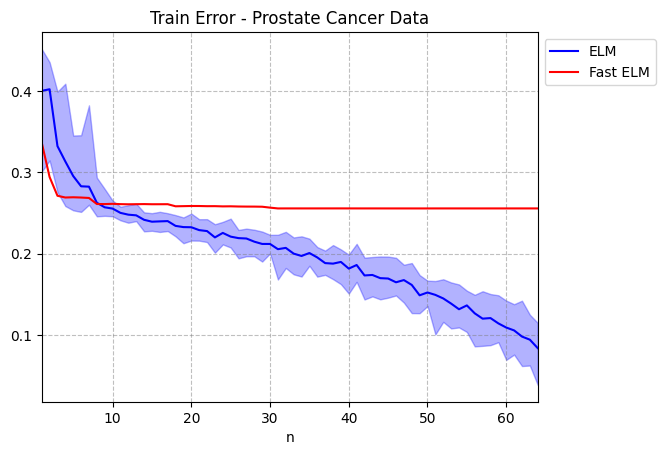

In [7]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.018948
0.06482699999999998


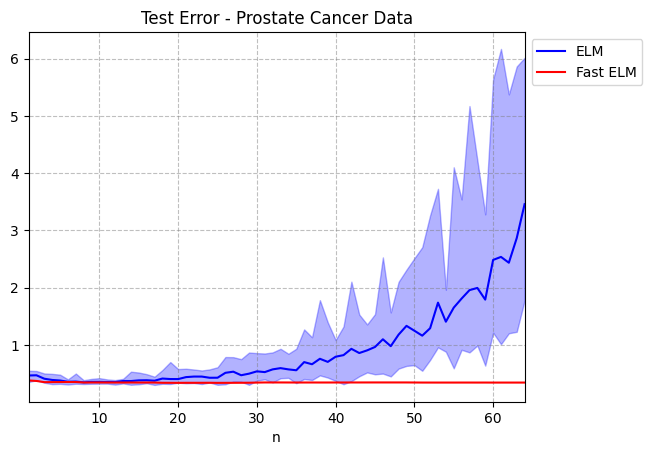

In [8]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Forest fires

In [1]:
#resets the environment
%reset -f -s 

In [2]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [3]:
seed_train_test_split = 1234

generator = datagenerator.LoaderDataGenerator("Forest Fires", dataloader.load_forest_fires)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)

T = X_train.shape[0]
n0 = X_train.shape[1]
print("dataset shape: " + str(X.shape))

Forest Fires
dataset shape: (517, 29)


In [5]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
348


In [6]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [7]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

4.8384958
11.7900319


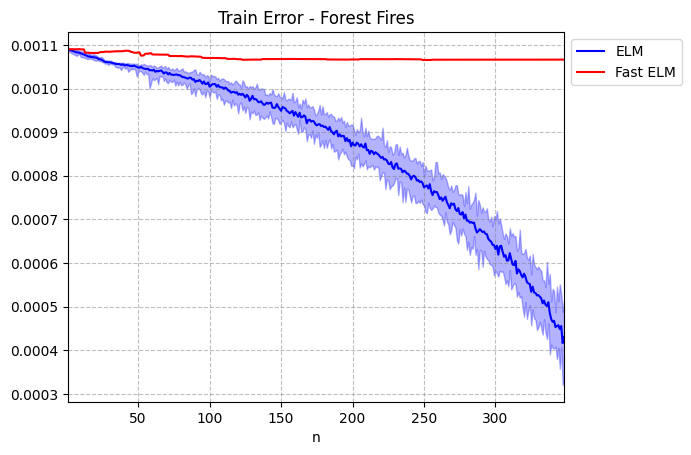

In [8]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


4.8384958
11.7900319


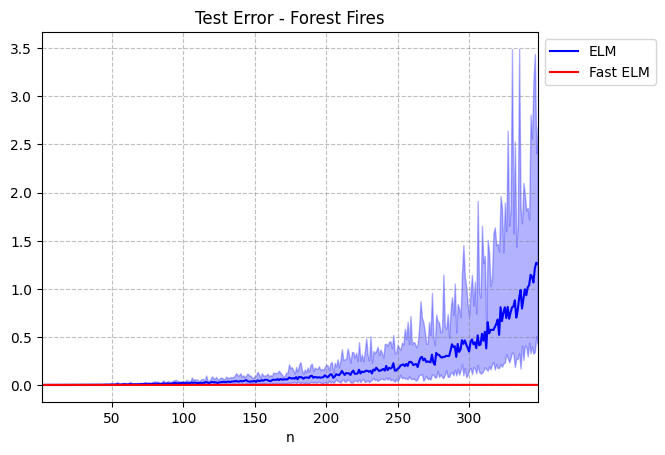

In [9]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### LA Ozone

In [15]:
#resets the environment
%reset -f -s 

In [16]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [17]:
seed_train_test_split = 1234

generator = datagenerator.LoaderDataGenerator("LA Ozone", dataloader.load_LAozone)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)

T = X_train.shape[0]
n0 = X_train.shape[1]
print("dataset shape: " + str(X.shape))

LA Ozone
dataset shape: (330, 9)


In [19]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
222


In [20]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [21]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

1.5833526
0.7606478000000001


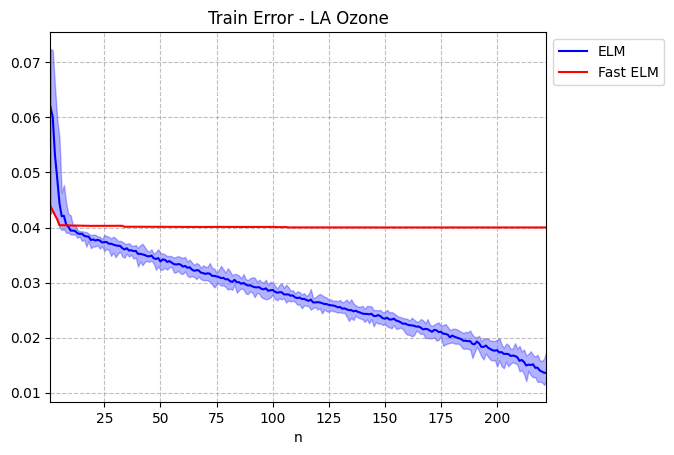

In [22]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


1.5833526
0.7606478000000001


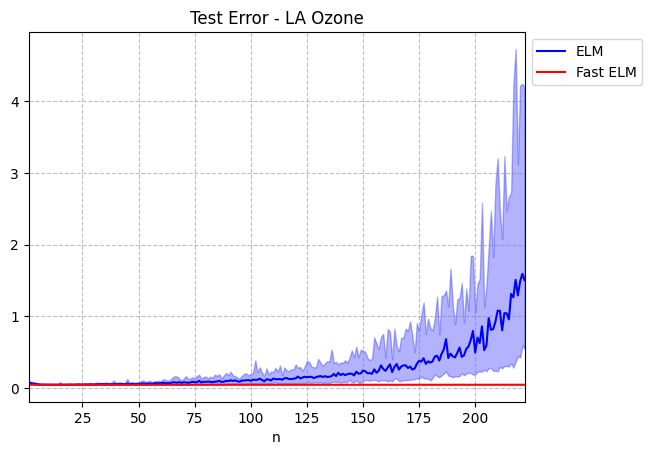

In [23]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Intrusion WSNS

In [1]:
#resets the environment
%reset -f -s 

In [2]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [3]:
seed_train_test_split = 1234

generator = datagenerator.LoaderDataGenerator("Intrusion WSNS", dataloader.load_intrusion_wsns)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)

T = X_train.shape[0]
n0 = X_train.shape[1]
print("dataset shape: " + str(X.shape))

Intrusion WSNS
dataset shape: (182, 10)


In [4]:
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [5]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...


LinAlgError: Singular matrix

In [ ]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [ ]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.018948
0.06482699999999998


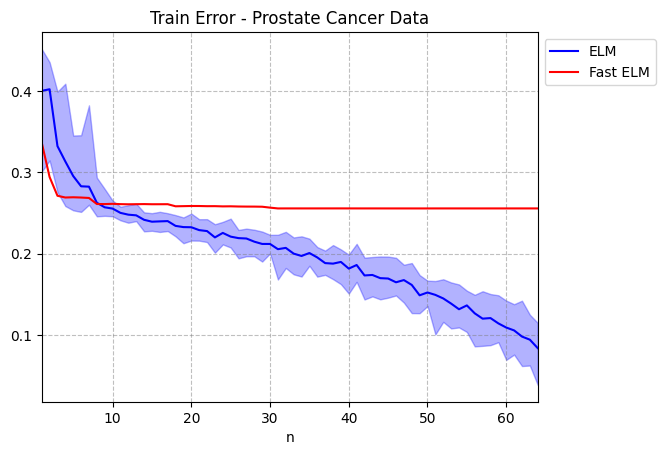

In [ ]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.018948
0.06482699999999998


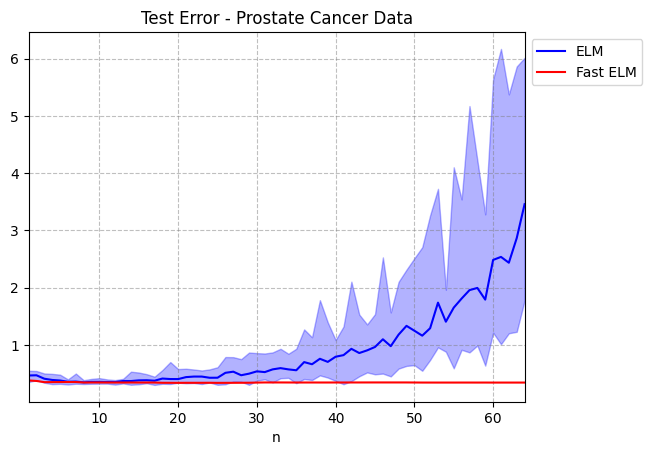

In [ ]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Abalone

In [1]:
#resets the environment
%reset -f -s 

In [2]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os

In [3]:
seed_train_test_split = 1234

generator = datagenerator.LoaderDataGenerator("Abalone", dataloader.load_abalone)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)

T = X_train.shape[0]
n0 = X_train.shape[1]
print("dataset shape: " + str(X.shape))

Abalone
dataset shape: (4177, 10)


In [4]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
1885


In [5]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [6]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

156.9027138
632.2684586000007


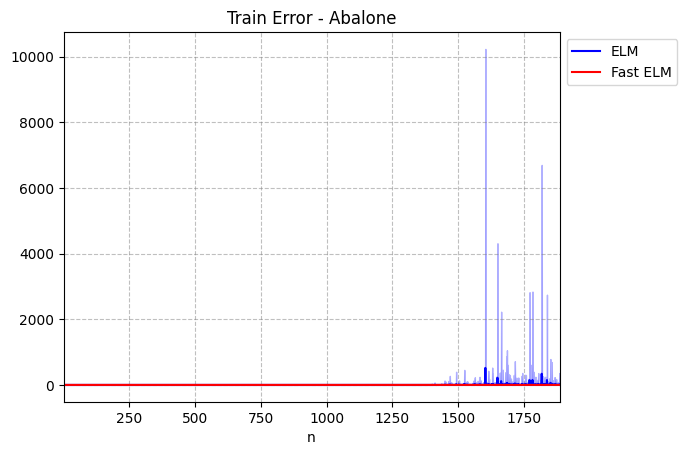

In [7]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


156.9027138
632.2684586000007


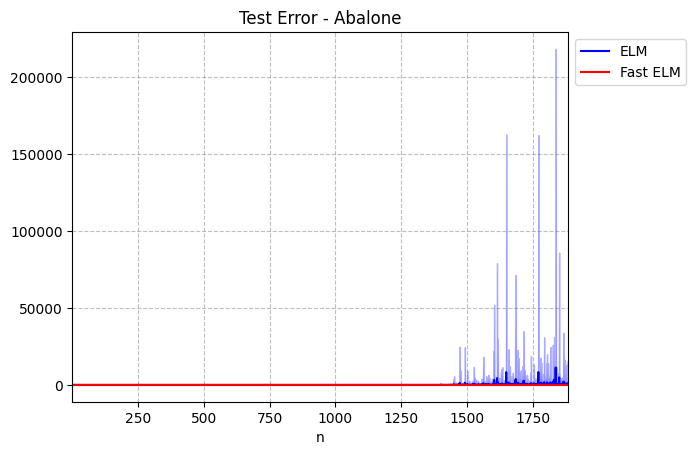

In [8]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))

### Delta-Ailerons

In [ ]:
#resets the environment
%reset -f -s 

In [ ]:
import numpy as np
import datagenerator
import dataloader
from elm import ELM, FastELM
from sklearn.model_selection import train_test_split
import utils
from time import time_ns
from matplotlib import pyplot as plt
import pandas as pd
import os


In [ ]:
seed_train_test_split = 1234


generator = datagenerator.LoaderDataGenerator("Delta-Ailerons", dataloader.load_delta_ailerons)
res = generator.generate()
print(res['name'])
X = res['data'][0]
y = res['data'][1]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = seed_train_test_split)
X_train, X_test, y_train, y_test, mean_y_train = utils.preprocess(X_train, X_test, y_train, y_test)
T = X_train.shape[0]
n0 = X_train.shape[1]
print("dataset shape: " + str(X.shape))

Delta-Ailerons
dataset shape: (7129, 5)


In [ ]:
train_err_FastELM = np.zeros(T)
test_err_FastELM = np.zeros(T)


total_time_FastELM = time_ns()
elm = FastELM(n0, T, "erf", None, Cb = 0.0, Cw = 1.0)

time_U_and_W_FastELM = time_ns()
_, U = elm.get_subspace(X_train, y_train, subset_by_value=[1e-4, np.inf]) #subset_by_value contains the range of eigenvalues to be considered
elm.select_W(X_train, U)
time_U_and_W_FastELM = (time_ns()- time_U_and_W_FastELM) / 1e9

time_fit_FastELM = time_ns()
elm.fit(U, y_train)
time_fit_FastELM = (time_ns() - time_fit_FastELM) / 1e9

#for i, n in enumerate(n_list):
for n in range(1,U.shape[1]+1):
    train_err_FastELM[n-1] = elm.score_n(X_train, y_train, n)
    test_err_FastELM[n-1] = elm.score_n(X_test, y_test, n)

total_time_FastELM = (time_ns() - total_time_FastELM) / 1e9

last_n = np.minimum(U.shape[1], int(0.9 * U.shape[0]))
train_err_FastELM = train_err_FastELM[0:last_n]
test_err_FastELM = test_err_FastELM[0:last_n]

print(last_n)

Computing erf K...
2990


In [ ]:
n_list = np.arange(1, last_n+1,1)
loops = 20
loops_train_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))
loops_test_err_ELM = np.zeros(shape=(loops,n_list.shape[0]))

times_ELM = {}
for loop in range(loops):
    for i, n in enumerate(n_list):
        start = time_ns()
        elm = ELM(n0, n, "erf", None)
        #elm.select_W(X_train, y_train, n_sample = 30) #n_sample contains the number of W samples to compare in cross_validation
        elm.fit(X_train, y_train)
        loops_train_err_ELM[loop, i] = elm.score(X_train, y_train)
        loops_test_err_ELM[loop, i] = elm.score(X_test, y_test)
        times_ELM[str(n)] = (time_ns() - start) / 1e9

train_err_ELM = np.mean(loops_train_err_ELM, axis = 0)
min_train_err_ELM = np.min(loops_train_err_ELM, axis = 0)
max_train_err_ELM = np.max(loops_train_err_ELM, axis = 0)
lower_errors_train_err_ELM = train_err_ELM - min_train_err_ELM + 1e-10
upper_errors_train_err_ELM = max_train_err_ELM - train_err_ELM + 1e-10

test_err_ELM = np.mean(loops_test_err_ELM, axis = 0)
min_test_err_ELM = np.min(loops_test_err_ELM, axis = 0)
max_test_err_ELM = np.max(loops_test_err_ELM, axis = 0)
lower_errors_test_err_ELM = test_err_ELM - min_test_err_ELM + 1e-10
upper_errors_test_err_ELM = max_test_err_ELM - test_err_ELM + 1e-10


In [ ]:
columns = ["n", "train_err_ELM", "min_train_error_ELM", "max_train_error_ELM", "train_error_FastELM", "test_err_ELM", "min_test_error_ELM",  "max_test_error_ELM", "test_error_FastELM"]
data_dict = {columns[0]: n_list,
             columns[1]: train_err_ELM,
             columns[2]: min_train_err_ELM,
             columns[3]: max_train_err_ELM,
             columns[4]: train_err_FastELM,
             columns[5]: test_err_ELM,
             columns[6]: min_test_err_ELM,
             columns[7]: max_test_err_ELM,
             columns[8]: test_err_FastELM}
df = pd.DataFrame(data_dict)
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/results.csv")

columns = ['T', 'max_n','total_time_ELM', 'total_time_FastELM', 'time_U_and_W_FastELM']
data_dict_time = {columns[0]: T,
             columns[1]: last_n,
             columns[2]: sum(times_ELM.values()),
             columns[3]: total_time_FastELM,
             columns[4]: time_U_and_W_FastELM}
df = pd.DataFrame(data_dict_time, index = [0])
os.makedirs("results/"+res['name'], exist_ok=True)
df.to_csv("results/"+res['name']+"/times.csv")

0.1251259
0.14446769999999995


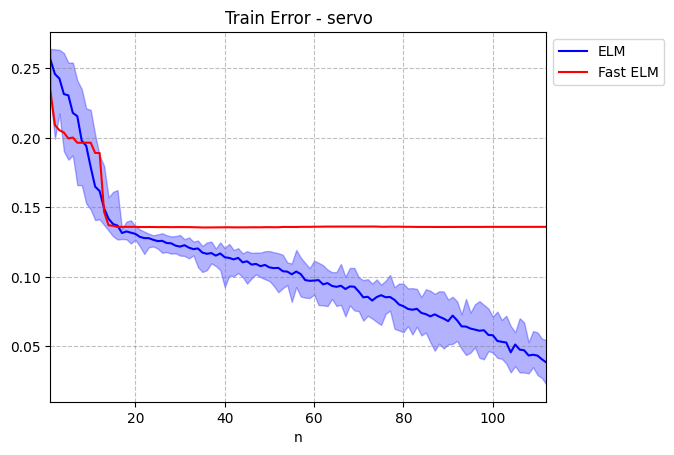

In [ ]:
plt.figure(1)
plt.title("Train Error - " + res['name'])
p11,=plt.plot(n_list, train_err_ELM,'b-') 
plt.fill_between(n_list, min_train_err_ELM, max_train_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p12,=plt.plot(n_list, train_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p11, p12], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))


0.1251259
0.14446769999999995


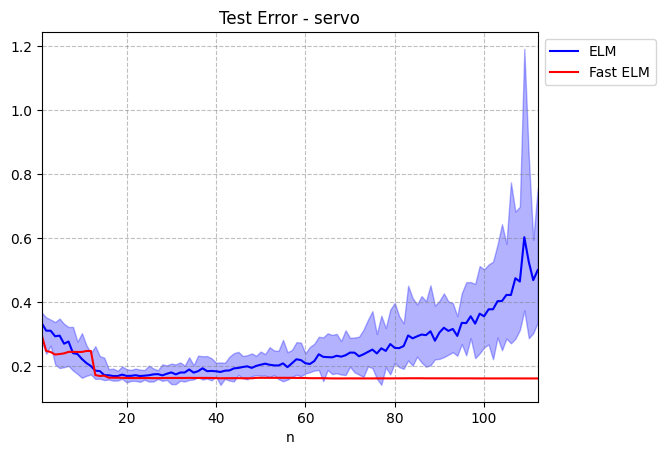

In [ ]:
plt.figure(2)
plt.title("Test Error - " + res['name'])
p21,=plt.plot(n_list, test_err_ELM,'b-') 
plt.fill_between(n_list, min_test_err_ELM, max_test_err_ELM, color='blue', alpha=0.3, label='test error ELM range')
p22,=plt.plot(n_list, test_err_FastELM,'r-')
plt.xlim(1,n_list[-1])
plt.xlabel("n")
plt.legend([p21, p22], ["ELM", "Fast ELM"],bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.5)

print(total_time_FastELM)
print(sum(times_ELM.values()))